In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIM = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIM], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIM])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 24.5 s, sys: 4.49 s, total: 29 s
Wall time: 28.4 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 512, 300), (5893, 9), (1474, 512, 300), (1474, 9))

In [6]:
filters = 256
kernel_size = 3
hidden_dims = 256
epochs = 10

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(filters,
                kernel_size,
                padding='valid',
                activation='relu',
                strides=1,
                input_shape=(MAX_LEN, EMBEDDING_DIM)
                ))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, 
                activation='relu'
               ))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 510, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 298,761
Trainable params: 298,761
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [9]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/10
5893/5893 [==============================] - 4s 741us/step - loss: 0.9588 - acc: 0.6845 - val_loss: 0.3376 - val_acc: 0.8860
Epoch 2/10
5893/5893 [==============================] - 2s 327us/step - loss: 0.2870 - acc: 0.9107 - val_loss: 0.2282 - val_acc: 0.9315
Epoch 3/10
5893/5893 [==============================] - 2s 325us/step - loss: 0.1457 - acc: 0.9581 - val_loss: 0.1616 - val_acc: 0.9498
Epoch 4/10
5893/5893 [==============================] - 2s 323us/step - loss: 0.0774 - acc: 0.9801 - val_loss: 0.1627 - val_acc: 0.9505
Epoch 5/10
5893/5893 [==============================] - 2s 327us/step - loss: 0.0407 - acc: 0.9896 - val_loss: 0.1602 - val_acc: 0.9478
Epoch 6/10
5893/5893 [==============================] - 2s 324us/step - loss: 0.0213 - acc: 0.9952 - val_loss: 0.1730 - val_acc: 0.9525
Epoch 7/10
5893/5893 [==============================] - 2s 337us/step - loss: 0.0188 - acc: 0.9956 - val_loss: 0.1596 - val_acc: 0.9539


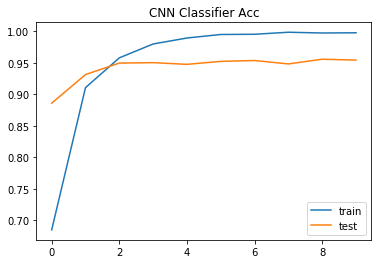

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CNN Classifier Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

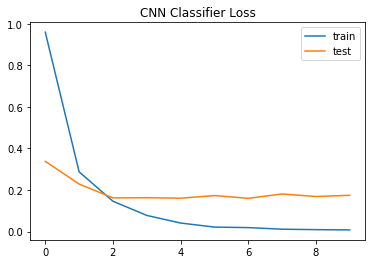

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CNN Classifier Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)
print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.935     0.909     0.922       175
  it-life-hack      0.906     1.000     0.951       154
 kaden-channel      1.000     0.970     0.985       167
livedoor-homme      0.968     0.798     0.875       114
   movie-enter      0.939     0.977     0.958       174
        peachy      0.900     0.929     0.914       184
          smax      0.984     0.978     0.981       186
  sports-watch      0.994     1.000     0.997       163
    topic-news      0.981     0.987     0.984       157

     micro avg      0.955     0.955     0.955      1474
     macro avg      0.956     0.950     0.952      1474
  weighted avg      0.956     0.955     0.954      1474



Normalized confusion matrix
[[0.909 0.011 0.    0.017 0.011 0.046 0.    0.    0.006]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.006 0.006 0.97  0.    0.    0.012 0.006 0.    0.   ]
 [0.009 0.061 0.    0.798 0.053 0.044 0.009 0.009 0.018]
 [0.    0.    0.    0.    0.977 0.023 0.    0.    0.   ]
 [0.043 0.005 0.    0.    0.016 0.929 0.005 0.    0.   ]
 [0.    0.022 0.    0.    0.    0.    0.978 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.006 0.006 0.    0.    0.    0.    0.    0.    0.987]]


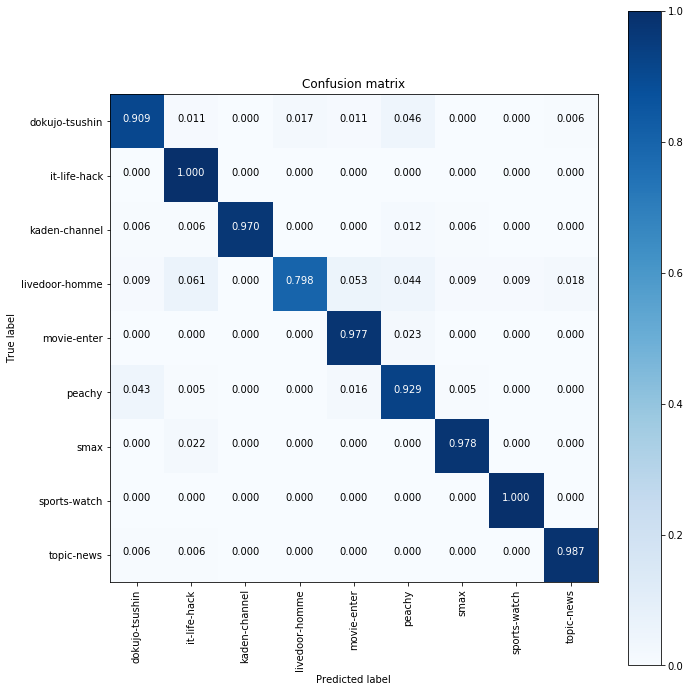

In [14]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)